In [1]:
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words as nltk_words
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import emoji
import swifter

#model
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import label_binarize


#visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


#nltk dependency
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/wawan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/wawan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /home/wawan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package words to /home/wawan/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [2]:
# loading dataset
# file_name = "blibli_app_review.csv"

data = pd.read_csv('output/blibli_app_review.csv')
data['content'].sample(10, random_state=None)

6171     Jelek saya main game top Eleven tiba² keluar s...
17189    Sengaja install buat nyobain fitur 2 jam sampa...
22429    hai blibli mau curhat dikit hehe. Sbnrnya udah...
20677                     Saya tidak bisa buat login nya👧🙏
9533     harganya ga masuk diakal,mehong2,coba buat bli...
24517                                           Dicoba dlu
26594    Masa mau tukar tambah hpku xiaomi redmi note 4...
1281                                                    ok
19151    kecewa banyak bug ..update sering ..tapi bnyak...
27625    ok sip aplikasi penghasil promo terbaik dan to...
Name: content, dtype: object

In [3]:
#selecting awal

#jika da panjang 'content' hanya senilai 4 atau null, maka drop
data_filtered = data[data['content'].str.split().str.len() >= 4].copy()
data_filtered = data_filtered[data_filtered['content'].str.strip() != '']

#ganti nama score -> rating
data_filtered = data_filtered.rename(columns={'score': 'rating'})

print("Jumlah data orisinil", data.shape)
print("Setelah filter:", data_filtered.shape)
data_filtered.head()

df = data_filtered.copy()

Jumlah data orisinil (40819, 8)
Setelah filter: (28699, 8)


## Rekayasa Fitur

In [4]:
#membuat labeling kelas
def label_sentimen(rating):
    if rating >= 4:
        return 'positif'
    elif rating <= 2:
        return 'negatif'
    else:
        return 'netral'

df['label'] = df['rating'].apply(label_sentimen)
dataframe = df

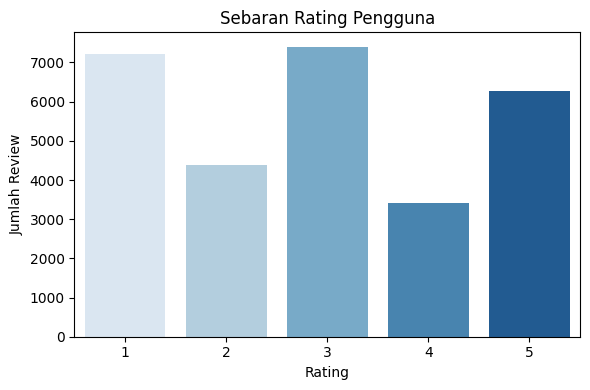

In [5]:
#visualisasi Sebaran Rating

plt.figure(figsize=(6, 4))
sns.countplot(data=dataframe, x='rating', palette='Blues')
plt.title('Sebaran Rating Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()


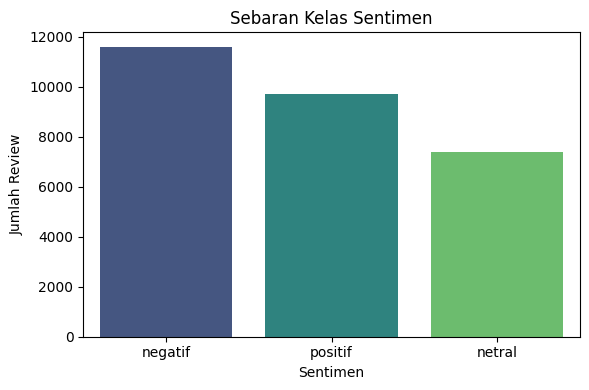

In [6]:
plt.figure(figsize=(6, 4))
sns.countplot(data=dataframe, x='label', palette='viridis')
plt.title('Sebaran Kelas Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah Review')
plt.tight_layout()
plt.show()

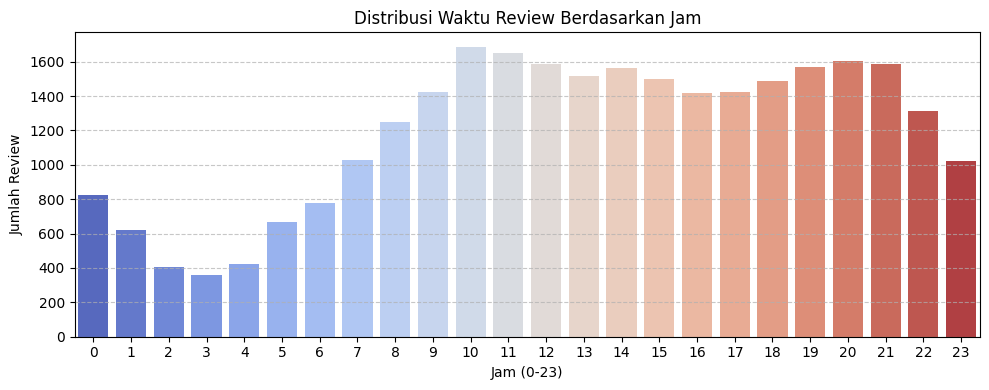

In [7]:
# Distribusi Review pengguna berdasarkan jam
dataframe['created_at'] = pd.to_datetime(dataframe['created_at'], errors='coerce')

df['hour'] = df['created_at'].dt.hour

plt.figure(figsize=(10, 4))
sns.countplot(data=dataframe, x='hour', palette='coolwarm')
plt.title('Distribusi Waktu Review Berdasarkan Jam')
plt.xlabel('Jam (0-23)')
plt.ylabel('Jumlah Review')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Text Preprocessing

In [11]:
positive_df = dataframe[dataframe['label'] == 'positif'].sample(min(2000, dataframe[dataframe['label'] == 'positif'].shape[0]), random_state=42)
netral_df = dataframe[dataframe['label'] == 'netral'].sample(min(2000, dataframe[dataframe['label'] == 'netral'].shape[0]), random_state=42)
negatif_df = dataframe[dataframe['label'] == 'negatif'].sample(min(2000, dataframe[dataframe['label'] == 'negatif'].shape[0]), random_state=42)


sampled_df = pd.concat([positive_df, netral_df, negatif_df])

sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Jumlah data setelah pengambilan 6500 sampel per kelas:", sampled_df.shape)
print("\nSebaran data per kelas setelah sampling:")
print(sampled_df['label'].value_counts())

dataframe = sampled_df.copy()


Jumlah data setelah pengambilan 6500 sampel per kelas: (6000, 10)

Sebaran data per kelas setelah sampling:
label
positif    2000
netral     2000
negatif    2000
Name: count, dtype: int64


In [16]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()

    # Hilangkan newline
    text = re.sub(r'\n', ' ', text)

    # Hilangkan URL
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Hilangkan mention dan hashtag
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Hilangkan angka dan tanda baca
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Hilangkan emoji
    text = emoji.replace_emoji(text, replace='')

    # Hilangkan spasi berlebihan
    text = re.sub(r'\s{2,}', ' ', text).strip()

    # Load kamus slang
    path_kamus = 'dataset/slangs.csv'
    kamus = pd.read_csv(path_kamus)
    kamus_dict = dict(zip(kamus['Slang'].astype(str).str.lower(), kamus['Baku'].astype(str).str.lower()))

    # Replacing slang
    words = text.split()
    normalized = [kamus_dict.get(word, word) for word in words]

    return ' '.join(normalized)

In [17]:
dataframe['cleaned'] = dataframe['content'].swifter.apply(clean_text)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [19]:
dataframe.shape
dataframe[['content', 'cleaned']].sample(20, random_state=None)

,content,cleaned
2128,Woi asu klo bikin iklan yg jelas lah gw main g...,woi asu kalau buat iklan yang jelas lah saya m...
5995,Ini beneran gratis ongkir gak sih?,ini beneran gratis biaya kirim tidak sih
183,Bro saya mau beli sepatu runing gak ada stok m...,bro saya mau beli sepatu runing tidak ada stok...
5358,Sudah hampir 3 tahun diriku berbelanja Online ...,sudah hampir tahun diriku berbelanja online di...
5777,MANTUL (MANTAP BETUL) 🥰🥰,mantap mantap betul
1312,Jeleknya kalo nagih ke tempat kerja bikin semu...,jeleknya kalau nagih ke tempat kerja buat semu...
5072,Dulu banget pake BliBli harga emang paling mah...,dulu sekali pakai blibli harga emang paling ma...
3154,"Ribet banget belanja nya,aku belum ngerti sii,...",ribet sekali belanja nyaaku belum ngerti siigk...
4260,keren banget bli bli,keren sekali beli beli
5572,Saya coba dulu ya,saya coba dulu ya


In [20]:
import re
import pandas as pd
from collections import Counter

def words(text):
    return re.findall(r'\w+', text.lower())

# Load dari slangs.csv
df = pd.read_csv('dataset/slangs.csv')
basic_words = df['Baku'].dropna().astype(str).str.lower().tolist()

# # Load dari kata_dasar_KBBI.txt
with open('dataset/kata_dasar_KBBI.txt', 'r', encoding='utf-8') as f:
  kbbi_lines = [line.strip().lower() for line in f if line.strip()]
  kbbi_words = []
  for line in kbbi_lines:
    kbbi_words.extend(line.split())

#kata kata bahasa inggris
ENGLISH_WORDS = set(word.lower() for word in nltk_words.words())

BRAND_WORDS = set([
    "blibli", "tokopedia", "bukalapak", "shopee", "lazada",
    "grab", "gojek", "indomaret", "alfamart", "bca", "bni", "bri",
    "mandiri", "gopay", "ovo", "dana", "linkaja", "jnt", "jne", "sicepat", "indomaret", "alfamart",
    "bank"
])

combined_words = basic_words + kbbi_words + list(ENGLISH_WORDS) + list(BRAND_WORDS)
WORD_SET = set(w for w in combined_words if w.strip() and len(w) > 1)
WORDS = Counter(w for w in combined_words if w in WORD_SET)
WORDS = Counter(combined_words)
WORD_SET = set(combined_words)


def P(word, N=sum(WORDS.values())):
    return WORDS[word] / N

def correction(word):
    return max(candidates(word), key=P)

def candidates(word):
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words):
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word):
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

def correct_sentence(sentence):
    tokens = re.findall(r'\w+', sentence.lower())
    corrected = [correction(word) for word in tokens]
    return ' '.join(corrected)

def segment(word, dictionary=WORD_SET):
    """Segment word menjadi kata-kata baku valid dari dictionary"""
    n = len(word)
    dp = [None] * (n + 1)
    dp[0] = []

    for i in range(1, n + 1):
        for j in range(i):
            if dp[j] is not None and word[j:i] in dictionary:
                dp[i] = dp[j] + [word[j:i]]
                break
    return dp[-1]

def expand_numeric_repetition(word):
    match = re.match(r'([a-z]+)(\d+)', word)
    if match:
        base, count = match.groups()
        try:
            repeat = int(count)
            return ' '.join([base] * repeat)
        except:
            pass
    return word

def normalize_word(word):
    raw_word = word  # simpan kata asli
    word = re.sub(r'[^\w\s]', '', word.lower())

    # Cek langsung dari raw lowercase
    if raw_word.lower() in BRAND_WORDS:
        return raw_word.lower()

    if word in BRAND_WORDS:
        return word

    if word in ENGLISH_WORDS:
        return word

    expanded = expand_numeric_repetition(word)
    if expanded != word:
        return ' '.join(normalize_word(w) for w in expanded.split())

    if ' ' in word:
        return ' '.join(normalize_word(w) for w in word.split())

    if word in WORD_SET and len(word) > 2:
        return word

    segmented = segment(word)
    if segmented and all(len(w) > 2 for w in segmented):
        return ' '.join(correction(w) for w in segmented)

    return correction(word)

def normalize_sentence(sentence):
    tokens = re.findall(r'\w+', sentence.lower())
    return ' '.join(normalize_word(token) for token in tokens)


In [21]:
#test fungsi
kalimat = "prduk tokpedia ggal apliks bsuk"
print(normalize_word(kalimat))

produk tokopedia gagal aplikasi busuk


In [22]:
import swifter
dataframe['replaced_slangs'] = dataframe['cleaned'].swifter.apply(correct_sentence)
dataframe['norm_norvig'] = dataframe['replaced_slangs'].swifter.apply(normalize_sentence)
dataframe['normalized_text'] = dataframe['norm_norvig']  # Alias untuk konsistensi


Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [23]:
pd.set_option('display.max_colwidth', None)
dataframe[["cleaned","normalized_text","label"]].sample(20)

,cleaned,normalized_text,label
3141,kecewa si sama pelayanan blibli sekarang sellernya banyak yang tidak pembaruan stok sudah klik bayar dan beberapa hari ko masih proses setelah ditanyakan chat penjual ternyata barang tidak ada stok setelah cancel proses pengembalian dana masuknya ke blipay tidak langsung rekening harus tarik dulu dan memakan waktu lagi so bad,kecewa si sama pelayanan blibli sekarang seller nya banyak yang tidak pembaruan stok sudah klik bayar dan beberapa hari ko masih proses setelah ditanakkan chat penjual ternyata barang tidak ada stok setelah cancel proses pengembalian dana masukan ke lipat tidak langsung rekening harus tarik dulu dan memakan waktu lagi so bad,negatif
4702,kalau beli leptop pasti pakai kayu paketnya,kalau beli laptop pasti pakai kayu paketan,netral
4631,kalau nanti ada yang cocok ditmbahin deh bintangnya,kalau nanti ada yang cocok ditmbahin deh bintangnya,netral
2033,usahan kn semua bareng bisa bayar di tempat kalau semua bareng bisa bayar di tempat pasti ini aplikasi nomor maaf ya aku sudah unistal lagi aku lebih milih lazada soalnya banyak yang tidak bisa cash on delivery,usaha ke semua bareng bisa bayar di tempat kalau semua bareng bisa bayar di tempat pasti ini aplikasi nomor maaf ya aku sudah unital lagi aku lebih silih lazada asalnya banyak yang tidak bisa cash on delivery,netral
2312,sedikit lambat kasih dulu,sedikit lambat kasih dulu,negatif
5144,customer service kocak tidak beri solusi malah nyesatin lebih baik tutup saja kamu di tokped sama shopee saja masi bisa revisi alamat kalau salah saya tidak mau tahu balikin duit saya,customer service kocak tidak beri solusi malah nye satin lebih baik tutup saja kamu di topped sama shopee saja mati bisa revisi alamat kalau salah saya tidak mau tahu balikan duit saya,negatif
5096,coba dulu ah,coba dulu ah,netral
741,pengiriman ke palu sudah lancar,pengiriman ke palu sudah lancar,positif
4812,kalau boleh tahu cara pembayaranya seperti gimana ya boleh tidak bayar di rumah tolong jelasin ya nantik kalau sudah di bales aku janji bakal nambahin bintang nya lagi makasi aku tunggu balasanya ya,kalau boleh tahu cara pembayaran seperti gimana ya boleh tidak bayar di rumah tolong kelamin ya nanti kalau sudah di balas aku janji bakal tambahan bintang nya lagi vakasi aku tunggu balasan ya,netral
711,ko tidak bisa cash on delivery yh,ko tidak bisa cash on delivery yg,positif


## Convert Negation

In [24]:
def convert_negation(text):
    negations = {'tidak', 'bukan', 'jangan', 'tak'}
    tokens = word_tokenize(text.lower())
    result = []
    skip_next = False

    for i in range(len(tokens)):
        if skip_next:
            skip_next = False
            continue
        if tokens[i] in negations and i+1 < len(tokens):
            result.append(tokens[i] + '_' + tokens[i+1])
            skip_next = True
        else:
            result.append(tokens[i])

    return ' '.join(result)


In [25]:
dataframe['convert_negation'] = dataframe['normalized_text'].swifter.apply(convert_negation)
pd.set_option('display.max_colwidth', None)
dataframe[["normalized_text",'convert_negation',"label"]].sample(20)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

,normalized_text,convert_negation,label
1748,tiga dulu kalau oke saya kasih foul,tiga dulu kalau oke saya kasih foul,netral
2522,barang yang dijual di blibli tidak lengkap dan sayangnya hasil caback tidak bisa disunahkan untuk beli pulsa blibli harus berubah kalau tidak mau hilang dari peradaban status milenial,barang yang dijual di blibli tidak_lengkap dan sayangnya hasil caback tidak_bisa disunahkan untuk beli pulsa blibli harus berubah kalau tidak_mau hilang dari peradaban status milenial,negatif
2699,parah bekerma atur alamat saja ketik nya ngenstuck² kagak jelas ni aplikasi,parah bekerma atur alamat saja ketik nya ngenstuck² kagak jelas ni aplikasi,negatif
5563,baru gabung semoga memuaskan,baru gabung semoga memuaskan,netral
4367,buat aplikasi blibli credit lapak aplikasi pihak lain susah sekali bertemu tele jadi kata ngabisin kota,buat aplikasi blibli credit lapak aplikasi pihak lain susah sekali bertemu tele jadi kata ngabisin kota,netral
3220,sangat kecewa karena barang yang saya pesan tidak datang sudah hampir seminggu,sangat kecewa karena barang yang saya pesan tidak_datang sudah hampir seminggu,negatif
5427,harga barang mahal mahal tidak bersaing dengan toko unline lain ya masa cari barang innuendo di saja tidak bisa kena konten,harga barang mahal mahal tidak_bersaing dengan toko unline lain ya masa cari barang innuendo di saja tidak_bisa kena konten,negatif
3873,aplikasi belanja unline yang sangat mengecewakan saya tidak akan pakai lagi aplikasi ini pelayanan nya sangat buruk,aplikasi belanja unline yang sangat mengecewakan saya tidak_akan pakai lagi aplikasi ini pelayanan nya sangat buruk,negatif
1068,mudah beli token dan cepat,mudah beli token dan cepat,positif
3038,alhamdulillah selama belanja di blibli tidak pernah ada masalah retur barang pun sangat mudah cuma kemarin sempat dibuat kesal untuk pembatalan barang yang sudah dibayar karena lupa memasukkan kode voucher harus menghubungi customer service dulu lalu dana dikemarikan dalam bentuk voucher dan ada expirer nya gaduh masa uang saya sendiri dibegitukan sih setidaknya seperti shopee tinggal klik batakan pesanan lalu uang kita langsung masuk ke shopee pay mungkin itu bisa dijadikan masukan untuk blibli terima kasih,alhamdulillah selama belanja di blibli tidak_pernah ada masalah retur barang pun sangat mudah cuma kemarin sempat dibuat kesal untuk pembatalan barang yang sudah dibayar karena lupa memasukkan kode voucher harus menghubungi customer service dulu lalu dana dikemarikan dalam bentuk voucher dan ada expirer nya gaduh masa uang saya sendiri dibegitukan sih setidaknya seperti shopee tinggal klik batakan pesanan lalu uang kita langsung masuk ke shopee pay mungkin itu bisa dijadikan masukan untuk blibli terima kasih,positif


## Stopword Removals

In [26]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

def remove_stopwords(text):
    return stopword.remove(text)

dataframe['no_stopwords'] = dataframe['convert_negation'].swifter.apply(remove_stopwords)

dataframe[['cleaned','no_stopwords' ,'label']].sample(20)


Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

,cleaned,no_stopwords,label
495,kalau bayar di indomaret gimana caranya,kalau bayar indomaret gimana caranda,netral
4652,e toll saldo berhasil tapi dana tidak ada setelah di pembaruan komunikasi chat ribetharus isi ini itupakai antrianterpaksa hapus,e toll saldo berhasil dana tidak_ada di pembaruan komunikasi chat ribet isi itu pakai ant rian terpaksa hapus,negatif
3683,saya sangat puas belanja di lazada,sangat puas belanja lazada,netral
5449,saya benci karena tidak bisa ikut lelang padahal nomer handphone saya sudah terdaftar,benci tidak_bisa ikut lelang padahal nomer handphone sudah terdaftar,negatif
4618,dulu blibli bisa kasih gratis biaya kirim untuk pengiriman sampai tidak sekarang sudah tidak ada keunggulan lagi dibanding ecommerce yang lain malah aplikasi nya memuat nya ampun dehh bagus bye,dulu blibli kasih gratis biaya kirim pengiriman tidak_sekarang tidak_ada keunggulan dinding commerce lain malah aplikasi nya memuat nya ampun deh bagus bye,negatif
630,tolong perbaiki applikasi blibli tidak bisa dibuka dari kmren tulisannya sistem dalam perbaikan selalu padahal mau cek status pesanan yang blum datang,terbaiki aplikasi blibli tidak_bisa buka karen tulisan nya sistem perbaikan selalu padahal mau cek status pesanan belum datang,netral
43,nanti saya tmbah bintangnyakurang bagusnya tidak da pembayaran finance coba diperbaharui biar ada,saya tambah bintangnya kurang baunya tidak_da pembayaran finance coba diperbaharui biar,netral
5063,gooooood subsidi biaya pengiriman cukup mbantu,gooooood subsidi biaya pengiriman cukup bantu,positif
3034,tadi sedikit lama dihubungkan dengan gopay dilakukan berulang kali baru nyambung terima kasih,tadi sedikit lama dibusungkan gopay dielakkan berulang kali baru nyambing terima kasih,positif
3751,untuk appnya bagus tapi mohon ditambahkan kecamatan bojongsarinya,punya bagus mohon tambahkan kecamatan bojong sari nya,netral


## Stemming


In [27]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def stemming(text):
  return stemmer.stem(text)

dataframe['stemmed'] = dataframe['no_stopwords'].swifter.apply(stemming)

Pandas Apply:   0%|          | 0/6000 [00:00<?, ?it/s]

In [36]:
# menampilkan 10 data hasil stemming
dataframe[['cleaned', 'stemmed', 'label']].sample(10)

,cleaned,stemmed,label
825,aplikasi gembeltop up token pln dari pagi sudah mau sore tidak masukduit sudah dipotong,aplikasi gembel top up token pln pagi mau sore tidak masuk duit potong,negatif
1890,pembaruan aplikasi selalu nih,baru aplikasi selalu nih,netral
3680,keren user interface bagus transaksi lengkap mudah cepat keep up the bagus work,keren user interface bagus transaksi lengkap mudah cepat keep up the bagus work,positif
5139,kalau bisa blanja dilazada saja jika barang rusak tinggal retrun pengembalian barang pun tidak ribet dan tidak kena biaya kirim kalau beli kebanyakan lapak tidak mau,kalau belanja lazada jika barang rusak tinggal return kembali barang tidak ribet tidak kena biaya kirim kalau beli banyak lapak tidak mau,negatif
5760,aplikasi belanja yang super lengkap dan mudah digunakanbravo buat blibli,aplikasi belanja super lengkap mudah digunakanbravo buat blibli,positif
5098,saya baru mau bergabung ini pembayarannya lewat transfer apa langsung nanti kalau sudah di kirim barangnya,baru mau gabung bayar nya lewat transfer apa langsung kalau di kirim belang,netral
3372,saya kasih dulu kalau jaket yang saya mau ada dan sesuai pesanan saya kasih penuh,kasih dulu kalau jaket mau dan sesuai pesan saya kasih penuh,negatif
3945,saya coba dulu kalau bagus bintang untuk sekarang saya mau pesan speaker asus zenphone max pro m,coba dulu kalau bagus bintang sekarang mau pesan speaker arus euphone max pro m,negatif
4417,banyak promonyaaa gratis ongkirnya juga banyakk tapi sayang sellernya belum banyak dan produk belum lengkap tapi so far so bagus,banyak promonyaaa gratis ongkir nya banyak sayang seller nya banyak produk lengkap so far so bagus,positif
2414,sistemnya seperti dulu lagi donk berapapun bisa bayar diindomaret terus freeong lagi donk yang luar jabodetabek sekarang beli beli pakai biaya kirim jadinya jarang pesan disini sekarang,sisteina dulu dok papan bayar indomaret terus freeing dok luar jabodetabek sekarang beli beli pakai biaya kirim jadi jarang pesan dini sekarang,netral


In [29]:
X_train, X_test, y_train, y_test = train_test_split(dataframe['stemmed'], dataframe['label'], test_size=0.2, random_state=42, stratify=dataframe['label'])

# Inisialisasi TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape X_train_tfidf:", X_train_tfidf.shape)
print("Shape X_test_tfidf:", X_test_tfidf.shape)


Shape X_train_tfidf: (4800, 5000)
Shape X_test_tfidf: (1200, 5000)


## Modeling Naive Bayes

Accuracy: 0.6842
Precision: 0.6869
Recall: 0.6842
ROC AUC Score (multiclass - OvR): 0.8404


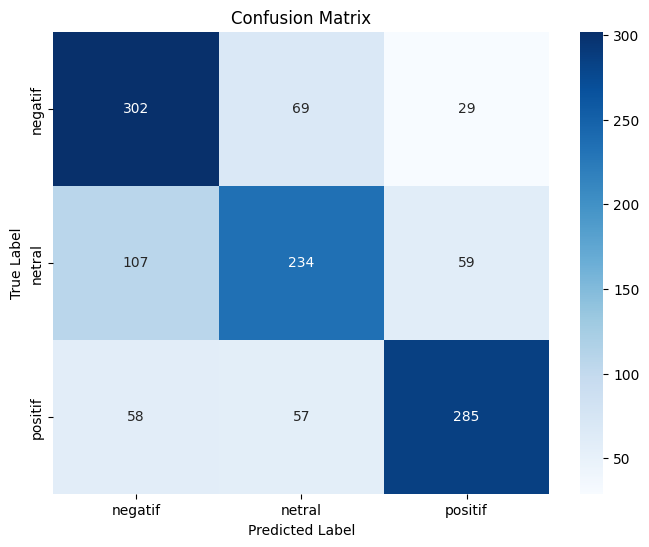

In [31]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns
import matplotlib.pyplot as plt

# Training
model = MultinomialNB(alpha=1.0, force_alpha=True, fit_prior=True)
model.fit(X_train_tfidf, y_train)

# Prediksi label
y_pred = model.predict(X_test_tfidf)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Hitung precision
precision = precision_score(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}")

# Hitung recall
recall = recall_score(y_test, y_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Hitung ROC AUC Score
# Dapatkan probabilitas dari model
y_score = model.predict_proba(X_test_tfidf)

# Binarisasi label y_test untuk multiclass AUC
classes = model.classes_
y_test_binarized = label_binarize(y_test, classes=classes)

# ROC AUC Score
roc_auc = roc_auc_score(y_test_binarized, y_score, multi_class='ovr', average='macro')
print(f"ROC AUC Score (multiclass - OvR): {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


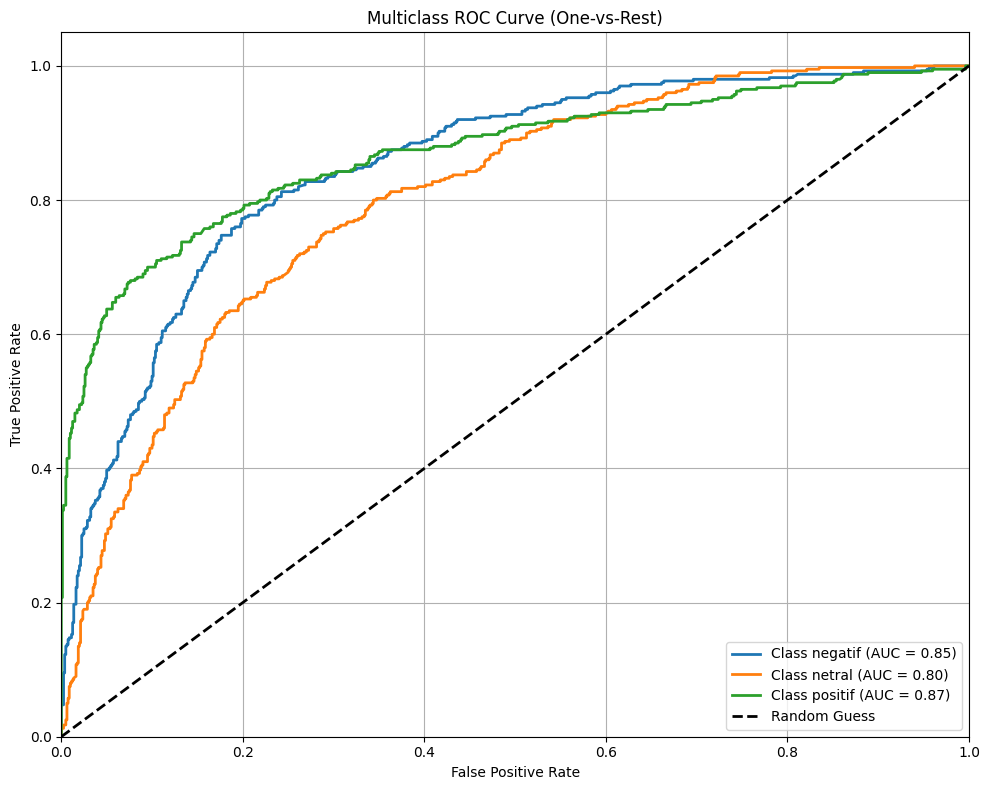

In [32]:
# Probabilitas prediksi
y_prob = model.predict_proba(X_test_tfidf)

lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)

classes = lb.classes_
n_classes = len(classes)

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.exceptions import NotFittedError

# Siapkan DataFrame hasil evaluasi
results = []

# Daftar model yang ingin diuji
models = {
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianNB": GaussianNB(),
    "ComplementNB": ComplementNB()
}

# Loop semua model
for model_name, model in models.items():
    try:
        # GaussianNB butuh array, bukan sparse matrix
        if model_name == "GaussianNB":
            model.fit(X_train_tfidf.toarray(), y_train)
            y_pred = model.predict(X_test_tfidf.toarray())
            y_proba = model.predict_proba(X_test_tfidf.toarray())
        else:
            model.fit(X_train_tfidf, y_train)
            y_pred = model.predict(X_test_tfidf)
            y_proba = model.predict_proba(X_test_tfidf)

        # Hitung metrik
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # ROC AUC multiclass (OvR)
        y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
        roc_auc = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')

        # Simpan ke results
        results.append({
            "Model": model_name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1,
            "ROC AUC": roc_auc
        })

    except Exception as e:
        # Tangani error model (misalnya tidak support proba, dsb)
        print(f"Model {model_name} error: {e}")
        continue

# Buat dataframe hasil evaluasi dan sorting
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by='F1-Score', ascending=False).reset_index(drop=True)

# Tampilkan hasil akhir
print("Hasil Evaluasi Model Naive Bayes (sorted by F1-Score):")
results_df_sorted


Hasil Evaluasi Model Naive Bayes (sorted by F1-Score):


,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC
0,MultinomialNB,0.684167,0.686919,0.684167,0.683277,0.840445
1,ComplementNB,0.676667,0.677852,0.676667,0.674817,0.840406
2,BernoulliNB,0.638333,0.671945,0.638333,0.641490,0.829295
3,GaussianNB,0.576667,0.594419,0.576667,0.576532,0.689853
